**Import Package**



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, concatenate
from keras.utils import to_categorical
from keras.losses import BinaryCrossentropy

In [2]:
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)


TensorFlow version: 2.12.0
NumPy version: 1.22.4
Pandas version: 1.5.3


**Read the Dataset**

In [3]:
data = pd.read_csv('Gabungan1.csv')

**Feature (Ingredients) & Label (Potential Allergies, Potential Diseases, Halal/Haram)**

In [4]:
# Pisahkan fitur (Ingredients) dan label (Potensial Allergies, Potensial Diseases, Halal/Haram)
X = data['Ingredients']
y_allergies = data['Potential Allergies']
y_diseases = data['Potential Diseases']
y_halal = data['Halal/Haram']

#Check the features and labels
print(data.columns)

Index(['Ingredients', 'Potential Allergies', 'Potential Diseases',
       'Halal/Haram'],
      dtype='object')


**Check the Class Name and the Number of the Class**

In [5]:
#Check the class name and the number of the class (Potential Allergies)
print('class_name:', data['Potential Allergies'].unique())
print('the number of class:', len(data['Potential Allergies'].unique()))

class_name: ['No Potential Allergies Detected' 'Seafood Allergy' 'Gluten Allergy'
 'Legume Allergy' 'Milk Allergy and Lactose Intolerance' 'Poultry Allergy'
 'Animal Protein Allergy']
the number of class: 7


In [6]:
#Check the class name and the number of the class (Potential Diseases)
print('class_name:', data['Potential Diseases'].unique())
print('the number of class:', len(data['Potential Diseases'].unique()))

class_name: ['No Potential Diseases Detected' 'Gout' 'Diabetes' 'Cholesterol'
 'Hypertension' 'Cholesterol, Gout' 'Hypertension, Gout'
 'Cholesterol, Hypertension, Gout']
the number of class: 8


In [7]:
#Check the class name and the number of the class (Halal/Haram)
print('class_name:', data['Halal/Haram'].unique())
print('the number of class:', len(data['Halal/Haram'].unique()))

class_name: ['Halal' 'Haram']
the number of class: 2


**Preprocessing Text**

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preprocessing teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
max_length = X_padded.shape[1]

**Encoding the Label**

In [9]:
# Inisialisasi LabelEncoder
label_encoder_allergies = LabelEncoder()
y_encoded_allergies = label_encoder_allergies.fit_transform(y_allergies)

label_encoder_diseases = LabelEncoder()
y_encoded_diseases = label_encoder_diseases.fit_transform(y_diseases)

label_encoder_halal = LabelEncoder()
y_encoded_halal = label_encoder_halal.fit_transform(y_halal)

# Membuat DataFrame baru untuk hasil preprocessing
preprocessed_data = pd.DataFrame({
    'Features': X,
    'Labels_Allergies': y_encoded_allergies,
    'Labels_Diseases': y_encoded_diseases,
    'Labels_Halal': y_encoded_halal
})

# Menampilkan seluruh data hasil preprocessing
print(preprocessed_data)

         Features  Labels_Allergies  Labels_Diseases  Labels_Halal
0       Asparagus                 4                7             0
1     Bell Pepper                 4                7             0
2        Broccoli                 4                7             0
3          Carrot                 4                7             0
4     Cauliflower                 4                7             0
..            ...               ...              ...           ...
728   Whey Powder                 3                7             0
729  Nata de coco                 4                7             0
730           Egg                 4                1             0
731          Fish                 4                7             0
732      Fructose                 4                3             0

[733 rows x 4 columns]


**Split the Dataset**

In [10]:
# Memisahkan data menjadi subset training (80%) dan test (20%)
X_train, X_test, y_train_allergies, y_test_allergies, y_train_diseases, y_test_diseases, y_train_halal, y_test_halal = train_test_split(
    X_padded, y_encoded_allergies, y_encoded_diseases, y_encoded_halal, test_size=0.2, random_state=42
)

# Memisahkan subset training menjadi subset training dan validation
X_train, X_val, y_train_allergies, y_val_allergies, y_train_diseases, y_val_diseases, y_train_halal, y_val_halal = train_test_split(
    X_train, y_train_allergies, y_train_diseases, y_train_halal, test_size=0.2, random_state=42
)

# Mengecek pembagian subset training, validation, testing
print("Jumlah data total:", len(X_padded))
print("Jumlah data training:", len(X_train))
print("Jumlah data validation:", len(X_val))
print("Jumlah data test:", len(X_test))

Jumlah data total: 733
Jumlah data training: 468
Jumlah data validation: 118
Jumlah data test: 147


**Determines the Number of Classes on the Label that has been Encoded**

In [11]:
# Menentukan jumlah kelas alergi dalam setiap label yang telah diencoding
num_classes_allergies = len(np.unique(y_encoded_allergies))
y_train_allergies_encoded = to_categorical(y_train_allergies, num_classes=num_classes_allergies)
y_test_allergies_encoded = to_categorical(y_test_allergies, num_classes=num_classes_allergies)

In [12]:
# Menentukan jumlah kelas penyakit dalam setiap label yang telah diencoding
num_classes_diseases = len(np.unique(y_encoded_diseases))
y_train_diseases_encoded = to_categorical(y_train_diseases, num_classes=num_classes_diseases)
y_test_diseases_encoded = to_categorical(y_test_diseases, num_classes=num_classes_diseases)

In [13]:
# Menentukan jumlah kelas halal/haram dalam setiap label yang telah diencoding
num_classes_halal = len(np.unique(y_encoded_halal))
y_train_halal_encoded = to_categorical(y_train_halal, num_classes=num_classes_halal)
y_test_halal_encoded = to_categorical(y_test_halal, num_classes=num_classes_halal)

**Build the Model Architecture**

In [14]:
# Input layer
input_layer = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_layer)

# Convolutional layers
conv1d_layer = Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(max_length, embedding_dim))(embedding_layer)

# Global max pooling layer
maxpool_layer = GlobalMaxPooling1D()(conv1d_layer)

# Fully connected layers for allergies classification
allergies_fc_layer = Dense(64, activation='relu')(maxpool_layer)
allergies_output = Dense(num_classes_allergies, activation='softmax', name='allergies_output')(allergies_fc_layer)

# Fully connected layers for diseases classification
diseases_fc_layer = Dense(32, activation='relu')(maxpool_layer)
diseases_output = Dense(num_classes_diseases, activation='softmax', name='diseases_output')(diseases_fc_layer)

# Fully connected layers for halal/haram classification
halal_fc_layer = Dense(64, activation='relu')(maxpool_layer)
halal_output = Dense(num_classes_halal, activation='softmax', name='halal_output')(halal_fc_layer)

# Define the model with multiple outputs
model = Model(inputs=input_layer, outputs=[allergies_output, diseases_output, halal_output])

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7, 100)       62400       ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 3, 128)       64128       ['embedding[0][0]']              
                                                                                                  
 global_max_pooling1d (GlobalMa  (None, 128)         0           ['conv1d[0][0]']                 
 xPooling1D)                                                                                  

**Compile the Model**

In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss={'allergies_output': 'sparse_categorical_crossentropy',
                    'diseases_output': 'sparse_categorical_crossentropy',
                    'halal_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

**Train the Model**

In [16]:
# Melatih model
history = model.fit(X_train, [y_train_allergies, y_train_diseases, y_train_halal], 
                    validation_data=(X_val, [y_val_allergies, y_val_diseases, y_val_halal]), 
                    batch_size=64, epochs=150)


Epoch 1/150
8/8 [==============================] - 3s 72ms/step - loss: 4.3962 - allergies_output_loss: 1.8079 - diseases_output_loss: 1.9876 - halal_output_loss: 0.6006 - allergies_output_accuracy: 0.6175 - diseases_output_accuracy: 0.5470 - halal_output_accuracy: 0.8590 - val_loss: 3.9020 - val_allergies_output_loss: 1.6194 - val_diseases_output_loss: 1.8497 - val_halal_output_loss: 0.4329 - val_allergies_output_accuracy: 0.6186 - val_diseases_output_accuracy: 0.5932 - val_halal_output_accuracy: 0.9661
Epoch 2/150
8/8 [==============================] - 0s 18ms/step - loss: 3.2785 - allergies_output_loss: 1.3452 - diseases_output_loss: 1.6326 - halal_output_loss: 0.3007 - allergies_output_accuracy: 0.7115 - diseases_output_accuracy: 0.6667 - halal_output_accuracy: 0.9679 - val_loss: 3.0606 - val_allergies_output_loss: 1.3577 - val_diseases_output_loss: 1.5454 - val_halal_output_loss: 0.1575 - val_allergies_output_accuracy: 0.6186 - val_diseases_output_accuracy: 0.5932 - val_halal_outp

**Save the Model**

In [17]:
model.save("model.h5")

# Convert the model to TensorFlow SavedModel format
tf.saved_model.save(model, 'path_to_save_model')

**Plot Accuracy**

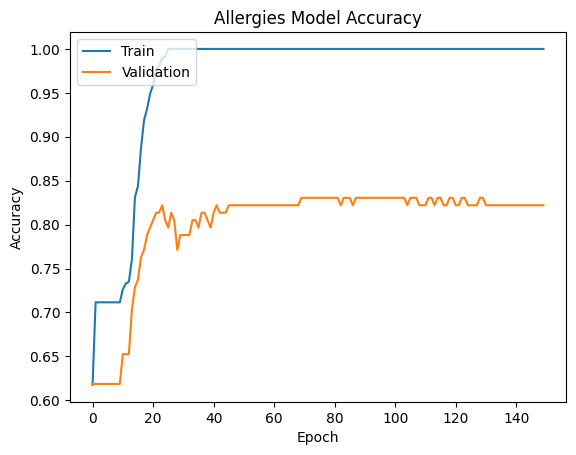

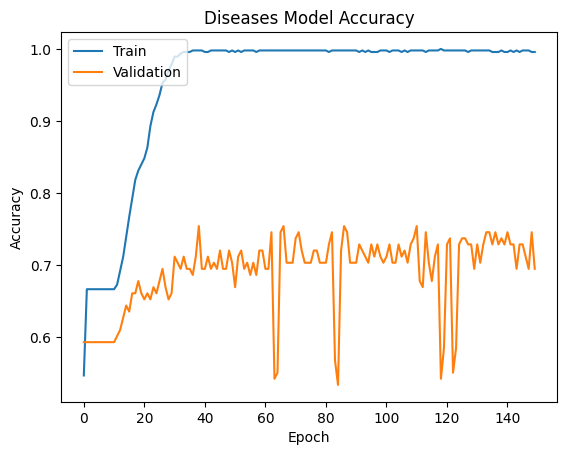

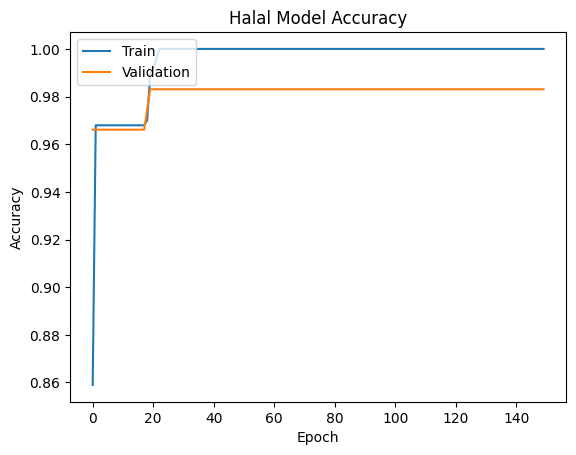

In [18]:
# Menampilkan plot akurasi alergi
plt.plot(history.history['allergies_output_accuracy'])
plt.plot(history.history['val_allergies_output_accuracy'])
plt.title('Allergies Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Menampilkan plot akurasi penyakit
plt.plot(history.history['diseases_output_accuracy'])
plt.plot(history.history['val_diseases_output_accuracy'])
plt.title('Diseases Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Menampilkan plot akurasi halal
plt.plot(history.history['halal_output_accuracy'])
plt.plot(history.history['val_halal_output_accuracy'])
plt.title('Halal Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


**Plot Loss**

In [19]:
# Menampilkan plot loss alergi
#plt.plot(history.history['allergies_output_loss'])
#plt.plot(history.history['val_allergies_output_loss'])
#plt.title('Allergies Model Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()

# Menampilkan plot loss penyakit
#plt.plot(history.history['diseases_output_loss'])
#plt.plot(history.history['val_diseases_output_loss'])
#plt.title('Diseases Model Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()

# Menampilkan plot loss halal
#plt.plot(history.history['halal_output_loss'])
#plt.plot(history.history['val_halal_output_loss'])
#plt.title('Halal Model Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()


**Evaluate the Model**

In [20]:
test_loss, test_allergies_loss, test_diseases_loss, test_halal_loss, test_allergies_acc, test_diseases_acc, test_halal_acc = model.evaluate(X_test, [y_test_allergies, y_test_diseases, y_test_halal])

print("Test Allergies Loss:", test_allergies_loss)
print("Test Diseases Loss:", test_diseases_loss)
print("Test Halal Loss:", test_halal_loss)
print("Test Allergies Accuracy:", test_allergies_acc)
print("Test Diseases Accuracy:", test_diseases_acc)
print("Test Halal Accuracy:", test_halal_acc)


5/5 [==============================] - 0s 4ms/step - loss: 2.5419 - allergies_output_loss: 1.2703 - diseases_output_loss: 1.1161 - halal_output_loss: 0.1555 - allergies_output_accuracy: 0.8844 - diseases_output_accuracy: 0.8095 - halal_output_accuracy: 0.9864
Test Allergies Loss: 1.2703237533569336
Test Diseases Loss: 1.1160703897476196
Test Halal Loss: 0.15554644167423248
Test Allergies Accuracy: 0.884353756904602
Test Diseases Accuracy: 0.8095238208770752
Test Halal Accuracy: 0.9863945841789246


**Test Predicting the Test Set** 

In [21]:
from sklearn.preprocessing import LabelEncoder

model = keras.models.load_model("model.h5")

# Misalkan X_new_data adalah data baru yang ingin Anda prediksi
data_uji = pd.read_csv('Gabungan1.csv')
X_new_data = data_uji['Ingredients']

# Lakukan preprocessing pada data baru (misalnya, tokenisasi dan pengkodean)
X_new_sequences = tokenizer.texts_to_sequences(X_new_data)
X_new_padded = pad_sequences(X_new_sequences, maxlen=max_length)

# Memprediksi data uji
y_pred_allergies, y_pred_diseases, y_pred_halal = model.predict(X_new_padded)

# Inisialisasi dan latih objek LabelEncoder untuk masing-masing label
label_encoder_allergies = LabelEncoder()
label_encoder_allergies.fit(y_allergies)

label_encoder_diseases = LabelEncoder()
label_encoder_diseases.fit(y_diseases)

label_encoder_halal = LabelEncoder()
label_encoder_halal.fit(y_halal)

# Menentukan label prediksi berdasarkan nilai probabilitas tertinggi
label_prediksi_allergies = label_encoder_allergies.inverse_transform(np.argmax(y_pred_allergies, axis=1))
label_prediksi_diseases = label_encoder_diseases.inverse_transform(np.argmax(y_pred_diseases, axis=1))
label_prediksi_halal = label_encoder_halal.inverse_transform(np.argmax(y_pred_halal, axis=1))

# Menampilkan hasil prediksi
for i in range(len(X_new_data)):
    print('Data:', X_new_data[i])
    print('Label Prediksi Allergy:', label_prediksi_allergies[i])
    print('Label Prediksi Diseases:', label_prediksi_diseases[i]) 
    print('Label Prediksi Halal / Haram:', label_prediksi_halal[i])   
    print('------------------------')


23/23 [==============================] - 0s 2ms/step
Data: Asparagus
Label Prediksi Allergy: No Potential Allergies Detected
Label Prediksi Diseases: No Potential Diseases Detected
Label Prediksi Halal / Haram: Halal
------------------------
Data: Bell Pepper
Label Prediksi Allergy: No Potential Allergies Detected
Label Prediksi Diseases: No Potential Diseases Detected
Label Prediksi Halal / Haram: Halal
------------------------
Data: Broccoli
Label Prediksi Allergy: No Potential Allergies Detected
Label Prediksi Diseases: No Potential Diseases Detected
Label Prediksi Halal / Haram: Halal
------------------------
Data: Carrot
Label Prediksi Allergy: No Potential Allergies Detected
Label Prediksi Diseases: No Potential Diseases Detected
Label Prediksi Halal / Haram: Halal
------------------------
Data: Cauliflower
Label Prediksi Allergy: No Potential Allergies Detected
Label Prediksi Diseases: No Potential Diseases Detected
Label Prediksi Halal / Haram: Halal
------------------------
Da

**Input Text Manual**

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Memisahkan input teks berdasarkan koma
input_text = input("Enter input text (separated by commas): ")
input_texts = input_text.split(",")

# Menginisialisasi variabel untuk hasil prediksi
allergies_output = []
diseases_output = []
halal_output = []

# Melakukan prediksi untuk setiap teks
for text in input_texts:
    # Preprocessing teks
    input_sequence = tokenizer.texts_to_sequences([text.strip()])
    input_padded = pad_sequences(input_sequence, maxlen=max_length)

    # Lakukan prediksi menggunakan model
    y_pred_allergies, y_pred_diseases, y_pred_halal = model.predict(input_padded)

    # Mengembalikan label prediksi menjadi bentuk aslinya
    label_prediksi_allergies = label_encoder_allergies.inverse_transform(np.argmax(y_pred_allergies, axis=1))
    label_prediksi_diseases = label_encoder_diseases.inverse_transform(np.argmax(y_pred_diseases, axis=1))
    label_prediksi_halal = label_encoder_halal.inverse_transform(np.argmax(y_pred_halal, axis=1))

    # Menggabungkan output dari beberapa teks
    allergies_output.extend(label_prediksi_allergies)
    diseases_output.extend(label_prediksi_diseases)
    halal_output.extend(label_prediksi_halal)

# Gabungkan hasil prediksi dari beberapa teks
combined_allergies_output = ' '.join(allergies_output)
combined_diseases_output = ' '.join(diseases_output)
combined_halal_output = ' '.join(halal_output)

if combined_allergies_output and "No Potential Allergies Detected" in allergies_output and len(allergies_output) > 1:
    non_no_allergies_output = [output for output in allergies_output if output != "No Potential Allergies Detected"]
    if non_no_allergies_output:
        final_allergies_output = ", ".join(non_no_allergies_output)
    else:
        final_allergies_output = "Allergy Prediction: No Potential Allergies Detected"
else:
    final_allergies_output = "Allergy Prediction: Sorry we can't detect it"


if combined_diseases_output and "No Potential Diseases Detected" in diseases_output and len(diseases_output) > 1:
    non_no_diseases_output = [output for output in diseases_output if output != "No Potential Diseases Detected"]
    if non_no_diseases_output:
      final_diseases_output = "Disease Prediction: " + ", ".join(non_no_diseases_output)
    else:
        final_diseases_output = "Disease Prediction: No Potential Diseases Detected"
else:
    final_diseases_output = "Disease Prediction: Sorry we can't detect it"


if final_allergies_output == "Allergy Prediction: Sorry we can't detect it" and final_diseases_output == "Disease Prediction: Sorry we can't detect it":
    final_halal_output = "Halal/Haram Prediction: Sorry we can't detect it"
else:
    if combined_halal_output:
        if "Haram" in halal_output:
            final_halal_output = "Halal/Haram Prediction: Haram"
        else:
            final_halal_output = "Halal/Haram Prediction: Halal"
    else:
        final_halal_output = "Halal/Haram Prediction: Sorry we can't detect it"


# Menampilkan hasil prediksi gabungan
print("Data: " + input_text)
print(final_allergies_output)
print(final_diseases_output)
print(final_halal_output)


Enter input text (separated by commas): carrot, powder
1/1 [==============================] - 0s 35ms/step
Data: carrot, powder
Gluten Allergy
Disease Prediction: No Potential Diseases Detected
Halal/Haram Prediction: Halal
